In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import re
import nltk
import operator
import numpy as np
import pandas as pd
from math import log
import urllib.request
from tqdm import tqdm
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize, sent_tokenize
from sklearn.feature_extraction.text import CountVectorizer

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# amazon = pd.read_csv('/content/drive/My Drive/amazon_reviews.csv')
binary_airline = pd.read_csv('/content/drive/My Drive/binary_air_review.csv')
# binary_hotel = pd.read_csv('/content/drive/My Drive/hotel-reviews.csv')
# clothing = pd.read_csv('/content/drive/My Drive/clothing.csv')
# movie = pd.read_csv('/content/drive/My Drive/train.csv')
# steam = pd.read_csv('/content/drive/My Drive/steam.csv')
# yelp = pd.read_csv('/content/drive/My Drive/yelp.csv')

In [ ]:
# sorting = amazon.sort_values(['label'])                     ## contents
sorting = binary_airline.sort_values(['rating'])            ## comment
# sorting = binary_hotel.sort_values(['Is_Response'])         ## Description
# sorting = clothing.sort_values(['Recommended IND'])         ## Review Text
# sorting = movie.sort_values(['sentiment'])                  ## text
# sorting = steam.sort_values(['user_suggestion'])            ## user_review
# sorting = yelp.sort_values(['rating'])                      ## review

In [ ]:
sorting

,Unnamed: 0,comment,rating
0,0,Good customer service thejith. Dealing with cu...,0
24897,24897,I have used WallyPark several times with very ...,0
24898,24898,Very happy and pleased with experience at Wall...,0
24899,24899,Will not park anywhere else! Quality of servic...,0
24900,24900,"Quality and service has fallen off, plus ended...",0
...,...,...,...
49776,103536,This was our first and last experience with Wa...,1
49777,103537,Had some really bad experiences: 1) Was LIED t...,1
49778,103538,Excellent service and excellent products! When...,1
49798,103558,Booked 3 rooms and was sent a misleading email...,1


In [ ]:
## 본문부분 열 이름과 점수부분 열 이름 입력

contents_name = "comment"
label_name = "rating"

In [ ]:
def data_loading(sorting, contents_name, label_name):

  review_ = sorting.reset_index()
  # 라벨 인코더 생성
  encoder = LabelEncoder()

  # X_train데이터를 이용 피팅하고 라벨숫자로 변환한다
  encoder.fit(review_[label_name])
  target_encoded = encoder.transform(review_[label_name])

  contents = list(np.array(review_[contents_name].tolist()))
  label = list(target_encoded)
  cnts_N = contents[:2000]+contents[-2000:]   ## X_train
  label_N = label[:2000]+label[-2000:]        ## y_train

  ## train data를 제외한 test data
  test_dict = {'document':contents[2000:-2000],"label":label[2000:-2000]}
  test_df = pd.DataFrame(test_dict)

  np.random.seed(0)

  df_shuffled=test_df.iloc[np.random.permutation(test_df.index)].reset_index(drop=True)
  df_shuffled

  tdata = df_shuffled['document']
  tlabel = df_shuffled['label']

  return cnts_N, label_N, tdata, tlabel

In [ ]:
## train test split과 같이 진행

train_X, train_Y, test_X, test_Y = data_loading(sorting, contents_name, label_name)

In [ ]:
def preprocessing(data):

    from nltk import FreqDist
    from nltk.stem.snowball import SnowballStemmer
    snowball = SnowballStemmer('english')

    normalized_text = []  ## 괄호 제거 및 문자이외의 데이터 제거
    for scr in data:
        scr = re.sub('\(', ' ', scr)
        scr = re.sub('\)', ' ', scr)
        scr = re.sub('[^ a-zA-Zㄱ-힗]', '', scr)
        normalized_text.append(scr.lower())

    result = [word_tokenize(sentence) for sentence in normalized_text]  ## 토큰화

    ## 단어 빈도 수 계산( 10번이상 등장하지 않는 단어 stopword에 포함 )
    vocab = list(set(w for i in result for w in i))
    vocab.sort()

    check_freq = []
    for line in result:
        for wd in line:
            check_freq.append(wd)

    fdist = FreqDist(check_freq)

    low_freq = []
    for i in vocab:
        if fdist[i] < 10:
            low_freq.append(i)

    stop_words = set(stopwords.words('english'))
    stop_words = list(stop_words)
    for i in low_freq:
        stop_words.append(i)

    ## stopwords 제거 및 stemming
    except_stopword = []
    for st in result:
        temp = []
        for tk in st:
            if tk not in stop_words:
                temp.append(snowball.stem(tk))
        except_stopword.append(temp)
    
    return except_stopword

In [ ]:
train_tokens = preprocessing(train_X)

리뷰의 최대 길이 : 606
리뷰의 평균 길이 : 71.26575


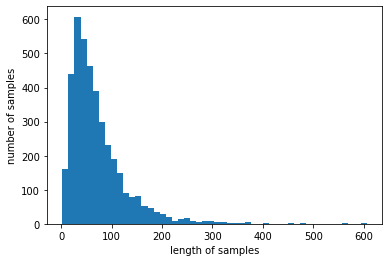

In [ ]:
print('리뷰의 최대 길이 :',max(len(l) for l in train_tokens))
print('리뷰의 평균 길이 :',sum(map(len, train_tokens))/len(train_tokens))
plt.hist([len(s) for s in train_tokens], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
vocabs = list(set(w for i in train_tokens for w in i ))
vocabs.sort()

In [ ]:
print('단어의 갯수는 총 %d개 이다'%(len(vocab)))

2301

In [ ]:
def corpus(tokens):
  corp = []
  for sent in tokens:
    tmp = " ".join(sent)
    corp.append(tmp)

  return corp

train_corp = corpus(train_tokens)

['westin wonder hotel bed linen excel pay internet',
 'excel hotel excel servic book superior king room upon check offer suit tower th floor free internet seper live area night turn main sister across street suit rd floor marriott overlook time squar higher floor told man check us happi play along assign room th floor room huge cours floor ceil window nice view river could even see empir state build behind sea okay suit sweet room larg flat tv coffe maker window would open decor beauti bit noisi could hear almost everyth hallway much one problem busi center printer work husband print someth concierg direct us nearbi abl use comput print got great deal night ever back nyc certain tri get deal excel hotel',
 'travel lot usual month year us middl east say order put staff lenox welcom continu help time room alway clean whole environ warm tradit nice mix modern free internet ipod station hd tvs make satisfactori locat superb major sight within walk distanc street prudenti copley squar right

Word Embedding

In [ ]:
from gensim.models import Word2Vec
max_len = int(sum(map(len, train_tokens))/len(train_tokens))
w2v_model = Word2Vec(sentences = train_tokens, size = 1)
w2v_matrix = w2v_model.wv.vectors

In [ ]:
index2word = {i+2: w for i, w in enumerate(w2v_model.wv.index2word)} 
index2word[0] = 'PAD'
index2word[1] = 'UNK'
word2index = {w: i for i, w in index2word.items() }
vocab_size = len(vocabs) + 2

행렬 생성

In [ ]:
from keras.preprocessing import sequence

num_recs = len(train_tokens)

X = np.empty((num_recs, ), dtype=list)     
y = np.zeros((num_recs, ))
i = 0

for sentence, label in zip(train_corp, train_Y):
    words = nltk.word_tokenize(sentence)  
    seqs = []
    for word in words:                 
        if word in word2index:         
            seqs.append(word2index[word])       
        else:
            seqs.append(word2index["UNK"])   

    X[i] = seqs              
    y[i] = int(label)        
    i += 1

In [ ]:
X_train = sequence.pad_sequences(X, maxlen=max_len)

In [ ]:
y_train = np.array(train_Y)
y_train = y_train.reshape(-1,1)

In [ ]:
X_test = preprocessing(test_X[:1000])

In [ ]:
new = np.empty((len(X_test), ), dtype= list)   # (1, ~) 벡터 만들기

for i, words in enumerate(X_test):
  seq = []
  for word in words:
    if word in word2index:
      seq.append(word2index[word])
    else:
      seq.append(word2index["UNK"])
  new[i] = seq

new_input = sequence.pad_sequences(new, maxlen=max_len)
new_input.shape

(1000, 71)

In [ ]:
y_test = np.array(test_Y[:1000])
y_test = y_test.reshape(-1,1)

# start LRP

In [ ]:
from __future__ import print_function
import numpy as np
import keras

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional


from keras.models import Model, load_model

import matplotlib.pyplot as plt
from IPython.display import display, HTML

from numpy import newaxis as na

In [ ]:
max_features = 10000
batch_size = 32

In [ ]:
num_classes = 2

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [ ]:
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(LSTM(64))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='sigmoid'))

model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

In [ ]:
print('Train...')
model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=10,
          validation_split = 0.2)

Train...
Epoch 1/10
100/100 [==============================] - 10s 78ms/step - loss: 0.6400 - accuracy: 0.6299 - val_loss: 0.5638 - val_accuracy: 0.7925
Epoch 2/10
100/100 [==============================] - 7s 69ms/step - loss: 0.3258 - accuracy: 0.8780 - val_loss: 0.4945 - val_accuracy: 0.7825
Epoch 3/10
100/100 [==============================] - 7s 69ms/step - loss: 0.2425 - accuracy: 0.9281 - val_loss: 0.7154 - val_accuracy: 0.7513
Epoch 4/10
100/100 [==============================] - 7s 68ms/step - loss: 0.1850 - accuracy: 0.9474 - val_loss: 0.6038 - val_accuracy: 0.8112
Epoch 5/10
100/100 [==============================] - 7s 66ms/step - loss: 0.1166 - accuracy: 0.9705 - val_loss: 0.8351 - val_accuracy: 0.7362
Epoch 6/10
100/100 [==============================] - 7s 69ms/step - loss: 0.1144 - accuracy: 0.9708 - val_loss: 0.8946 - val_accuracy: 0.7400
Epoch 7/10
100/100 [==============================] - 7s 68ms/step - loss: 0.0828 - accuracy: 0.9776 - val_loss: 0.6257 - val_accura

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         1280000   
_________________________________________________________________
lstm (LSTM)                  (None, 64)                49408     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 2)                 130       
Total params: 1,329,538
Trainable params: 1,329,538
Non-trainable params: 0
_________________________________________________________________


In [ ]:
results = model.evaluate(new_input, y_test)

32/32 [==============================] - 1s 12ms/step - loss: 0.6527 - accuracy: 0.8160


In [ ]:
model.save('lstm.h5')

In [ ]:
def html_heatmap (words, scores, cmap_name="bwr"):
    """
    Return word-level heatmap in HTML format,
    with words being the list of words (as string),
    scores the corresponding list of word-level relevance values,
    and cmap_name the name of the matplotlib diverging colormap.
    """
    
    colormap  = plt.get_cmap(cmap_name)
     
    #assert len(words)==len(scores)
    max_s     = max(scores)
    min_s     = min(scores)
    
    output_text = ""
    
    for idx, w in enumerate(words):
        score       = rescale_score_by_abs(scores[idx], max_s, min_s)
        output_text = output_text + span_word(w, score, colormap) + " "
    
    return output_text + "\n"

def rescale_score_by_abs (score, max_score, min_score):
    """
    Normalize the relevance value (=score), accordingly to the extremal relevance values (max_score and min_score), 
    for visualization with a diverging colormap.
    i.e. rescale positive relevance to the range [0.5, 1.0], and negative relevance to the range [0.0, 0.5],
    using the highest absolute relevance for linear interpolation.
    """
    
    # CASE 1: positive AND negative scores occur --------------------
    if max_score>0 and min_score<0:
    
        if max_score >= abs(min_score):   # deepest color is positive
            if score>=0:
                return 0.5 + 0.5*(score/max_score)
            else:
                return 0.5 - 0.5*(abs(score)/max_score)

        else:                             # deepest color is negative
            if score>=0:
                return 0.5 + 0.5*(score/abs(min_score))
            else:
                return 0.5 - 0.5*(score/min_score)   
    
    # CASE 2: ONLY positive scores occur -----------------------------       
    elif max_score>0 and min_score>=0: 
        if max_score == min_score:
            return 1.0
        else:
            return 0.5 + 0.5*(score/max_score)
    
    # CASE 3: ONLY negative scores occur -----------------------------
    elif max_score<=0 and min_score<0: 
        if max_score == min_score:
            return 0.0
        else:
            return 0.5 - 0.5*(score/min_score)
          

def getRGB (c_tuple):
    return "#%02x%02x%02x"%(int(c_tuple[0]*255), int(c_tuple[1]*255), int(c_tuple[2]*255))

     
def span_word (word, score, colormap):
    return "<span style=\"background-color:"+getRGB(colormap(score))+"\">"+word+"</span>"

In [ ]:
def get_layer_output(layer_name, data):
    # https://keras.io/getting-started/faq/#how-can-i-obtain-the-output-of-an-intermediate-layer
    intermediate_layer_model = keras.Model(inputs=model.input,
                                     outputs=model.get_layer(layer_name).output)
    return intermediate_layer_model.predict(data)

In [ ]:
names = [weight.name for layer in model.layers for weight in layer.weights]
weights = model.get_weights()

# suppress scientific notation
np.set_printoptions(suppress=True)
for name, weight in zip(names, weights):
    if name == 'lstm/lstm_cell/kernel:0':
        kernel_0 = weight
    if name == 'lstm/lstm_cell/recurrent_kernel:0':
        recurrent_kernel_0 = weight
    if name == 'lstm/lstm_cell/bias:0':
        bias_0 = weight
    elif name == 'dense/kernel:0':
        output = weight

In [ ]:
names

['embedding/embeddings:0',
 'lstm/lstm_cell/kernel:0',
 'lstm/lstm_cell/recurrent_kernel:0',
 'lstm/lstm_cell/bias:0',
 'dense/kernel:0',
 'dense/bias:0']

In [ ]:
print("kernel_0", kernel_0.shape)
print("recurrent_kernel_0", recurrent_kernel_0.shape)
print("bias_0", bias_0.shape)
print("output", output.shape)

# self.Wxh_Left (240, 60)
# self.Whh_Left (240, 60)
# self.bxh_Left (240,)
# self.Why_Left (5, 60)

kernel_0 (128, 256)
recurrent_kernel_0 (64, 256)
bias_0 (256,)
output (64, 2)


In [ ]:
Wxh = kernel_0.T  # shape 4d*e
Whh = recurrent_kernel_0.T  # shape 4d
bxh = bias_0.T  # shape 4d 
Why = output.T

print("Wxh", Wxh.shape)
print("Whh", Whh.shape)
print("bxh", bxh.shape)
print("Why", Why.shape)

Wxh (256, 128)
Whh (256, 64)
bxh (256,)
Why (2, 64)


In [ ]:
def lrp_linear(hin, w, b, hout, Rout, bias_nb_units, eps, bias_factor=0.0, debug=False):
    """
    LRP for a linear layer with input dim D and output dim M.
    Args:
    - hin:            forward pass input, of shape (D,)
    - w:              connection weights, of shape (D, M)
    - b:              biases, of shape (M,)
    - hout:           forward pass output, of shape (M,) (unequal to np.dot(w.T,hin)+b if more than one incoming layer!)
    - Rout:           relevance at layer output, of shape (M,)
    - bias_nb_units:  total number of connected lower-layer units (onto which the bias/stabilizer contribution is redistributed for sanity check)
    - eps:            stabilizer (small positive number)
    - bias_factor:    set to 1.0 to check global relevance conservation, otherwise use 0.0 to ignore bias/stabilizer redistribution (recommended)
    Returns:
    - Rin:            relevance at layer input, of shape (D,)
    """
    sign_out = np.where(hout[na,:]>=0, 1., -1.) # shape (1, M)
    
    numer    = (w * hin[:,na]) + ( bias_factor * (b[na,:]*1. + eps*sign_out*1.) / bias_nb_units ) # shape (D, M)
    # Note: here we multiply the bias_factor with both the bias b and the stabilizer eps since in fact
    # using the term (b[na,:]*1. + eps*sign_out*1.) / bias_nb_units in the numerator is only useful for sanity check
    # (in the initial paper version we were using (bias_factor*b[na,:]*1. + eps*sign_out*1.) / bias_nb_units instead)
    
    denom    = hout[na,:] + (eps*sign_out*1.)   # shape (1, M)
    
    message  = (numer/denom) * Rout[na,:]       # shape (D, M)
    
    Rin      = message.sum(axis=1)              # shape (D,)
    
    if debug:
        print("local diff: ", Rout.sum() - Rin.sum())
    # Note: 
    # - local  layer   relevance conservation if bias_factor==1.0 and bias_nb_units==D (i.e. when only one incoming layer)
    # - global network relevance conservation if bias_factor==1.0 and bias_nb_units set accordingly to the total number of lower-layer connections 
    # -> can be used for sanity check
    
    return Rin

In [ ]:
def LRP(target_data, target_class) :
    
    #원본 소스에서 E embedding은 전체에 대한 단어 사전이고, x는 embedding된 인풋이다.  

    x = get_layer_output('embedding', target_data).squeeze(axis=1)
    e = x.shape[1]

   ################# forword
    T = target_data.shape[0]
    d = int(256/4)  # hidden units
    C = Why.shape[0] # number of classes
    
    idx    = np.hstack((np.arange(0,d), np.arange(2*d,4*d))).astype(int) # indices of gates i,f,o together
    idx_i, idx_g, idx_f, idx_o = np.arange(0,d), np.arange(d,2*d), np.arange(2*d,3*d), np.arange(3*d,4*d) # indices of gates i,g,f,o separately

    h  = np.zeros((T,d))
    c  = np.zeros((T,d))

    gates_xh  = np.zeros((T, 4*d))  
    gates_hh  = np.zeros((T, 4*d)) 
    gates_pre = np.zeros((T, 4*d))  
    gates     = np.zeros((T, 4*d))  

    for t in range(T):
        gates_xh[t]     = np.dot(Wxh, x[t])
        gates_hh[t]     = np.dot(Whh, h[t-1])
        gates_pre[t]    = gates_xh[t] + gates_hh[t] + bxh
        gates[t, idx]    = 1.0/(1.0 + np.exp(- gates_pre[t,idx]))
        gates[t,idx_g]  = np.tanh(gates_pre[t,idx_g]) 
        c[t]            = gates[t,idx_f]*c[t-1] + gates[t,idx_i]*gates[t,idx_g]
        h[t]            = gates[t,idx_o]*np.tanh(c[t])

    s = np.dot(Why, h[t])    

    ################# backwork
    dx     = np.zeros(x.shape)

    dh          = np.zeros((T, d))
    dc          = np.zeros((T, d))
    dgates_pre  = np.zeros((T, 4*d))  # gates pre-activation
    dgates      = np.zeros((T, 4*d))  # gates activation

    ds               = np.zeros((C))
    ds[target_class] = 1.0
    dy               = ds.copy()

    #맨처음을 0으로 시작하지 않게 위한조치
    dh[T-1]     = np.dot(Why.T, dy)

    for t in reversed(range(T)): 
        dgates[t,idx_o]    = dh[t] * np.tanh(c[t])  # do[t]
        dc[t]             += dh[t] * gates[t,idx_o] * (1.-(np.tanh(c[t]))**2) # dc[t]
        dgates[t,idx_f]    = dc[t] * c[t-1]         # df[t]
        dc[t-1]            = dc[t] * gates[t,idx_f] # dc[t-1]
        dgates[t,idx_i]    = dc[t] * gates[t,idx_g] # di[t]
        dgates[t,idx_g]    = dc[t] * gates[t,idx_i] # dg[t]
        dgates_pre[t,idx]  = dgates[t,idx] * gates[t,idx] * (1.0 - gates[t,idx]) # d ifo pre[t]
        dgates_pre[t,idx_g]= dgates[t,idx_g] *  (1.-(gates[t,idx_g])**2) # d g pre[t]
        dh[t-1]            = np.dot(Whh.T, dgates_pre[t])
        dx[t]              = np.dot(Wxh.T, dgates_pre[t])

    ################# LRP
    eps=0.001 
    bias_factor=0.0
    Rx  = np.zeros(x.shape)
    Rh  = np.zeros((T+1, d))
    Rc  = np.zeros((T+1, d))
    Rg  = np.zeros((T,   d)) # gate g only

    Rout_mask            = np.zeros((C))
    Rout_mask[target_class] = 1.0  

    # format reminder: lrp_linear(hin, w, b, hout, Rout, bias_nb_units, eps, bias_factor)
    Rh[T-1]  = lrp_linear(h[T-1], Why.T, np.zeros((C)), s, s*Rout_mask, 2*d, eps, bias_factor, debug=False)  

    for t in reversed(range(T)):
        Rc[t]   += Rh[t]
        Rc[t-1]  = lrp_linear(gates[t,idx_f]*c[t-1], np.identity(d), np.zeros((d)), c[t], Rc[t], 2*d, eps, bias_factor, debug=False)
        Rg[t]    = lrp_linear(gates[t,idx_i]*gates[t,idx_g], np.identity(d), np.zeros((d)), c[t], Rc[t], 2*d, eps, bias_factor, debug=False)
        Rx[t]    = lrp_linear(x[t], Wxh[idx_g].T, bxh[idx_g], gates_pre[t,idx_g], Rg[t], d+e, eps, bias_factor, debug=False)
        Rh[t-1]  = lrp_linear(h[t-1], Whh[idx_g].T, bxh[idx_g], gates_pre[t,idx_g], Rg[t], d+e, eps, bias_factor, debug=False)    

    return s, dx, Rx, Rh[-1].sum()

In [ ]:
def index_to_word(word):
    full_sentence = ' '.join(index2word.get(w) for w in word)
    return full_sentence.split()

In [ ]:
def int_to_str(target_class):
    if target_class == 0 :
        return "긍정"
    else :
        return "부정"

In [ ]:
i = 0

target_data = np.array(new_input[i])
target_class = np.argmax(y_train[i])
predictions = model.predict(new_input)

scores, Gx, Rx, R_rest = LRP(target_data, target_class)

R_words          = np.sum(Rx, axis=1)                       # compute word-level LRP relevances
R_words_SA       = (np.linalg.norm(Gx,ord=2, axis=0))**2   # compute word-level Sensitivity Analysis relevances
R_words_GI       = np.dot(target_data, Gx) 


words = index_to_word(target_data)

if len(words) > 0 :
    print(" 예측 레이블:", int_to_str(np.argmax(predictions[i])), "| 실제 레이블 : ", int_to_str(target_class))

    print("        LRP heatmap:")
    display(HTML(html_heatmap(words, R_words)))

    print("        SA heatmap:")
    display(HTML(html_heatmap(words, R_words_SA)))

    print("        GI heatmap:")
    display(HTML(html_heatmap(words, R_words_GI)))

    print("-----------------------------------------------------------")

 예측 레이블: 긍정 | 실제 레이블 :  긍정
        LRP heatmap:


        SA heatmap:


        GI heatmap:


-----------------------------------------------------------


In [ ]:
predictions = model.predict(new_input)

In [ ]:
## 특정 점수 이상의 단어들만 사전생성하는데 사용된다.
## cut-off 설정 가능

def make_dict(x_, y_, thres : float, break_ : int):
  sent_dict = {}
  predictions = model.predict(x_)
  j = 0
  for i in range(len(x_)):
    
    if i % 100 == 0:
      print( i,'/',len(x_))

    if max(predictions[i]) > thres : 
      
      target_data = np.array(x_[i])
      target_class = np.argmax(y_[i])
    
      scores, Gx, Rx, R_rest = LRP(target_data, target_class)

      R_words          = np.sum(Rx, axis=1)                       # compute word-level LRP relevances
      # R_words_SA       = (np.linalg.norm(Gx,ord=2, axis=0))**2   # compute word-level Sensitivity Analysis relevances
      # R_words_GI       = np.dot(target_data, Gx) 
      words = index_to_word(target_data)
      if target_class == 1:
        tmp = {k:v for k,v in zip(words,R_words)}
      else:
        tmp = {k:-v for k,v in zip(words,R_words)}
      
      for k,v in tmp.items():
        if k in sent_dict:
          if abs(sent_dict[k]) < abs(v):
            sent_dict[k] = v
          else :
            None
        else :
          sent_dict[k] = v
      j+=1
      
    if j == break_:
        break
      

  return sent_dict

In [ ]:
sent_dict = make_dict(X_train, y_train, 0.8, 700)

In [ ]:
sorted(sent_dict.items(),key=operator.itemgetter(1))

In [ ]:
sorted(sent_dict.items(),key=operator.itemgetter(1), reverse= True)

In [ ]:
sent_dict.pop('PAD')

In [ ]:
## 부호를 이용해서 긍부정 단어 구분

def seperate(sent_dict):
  pos_ = {}
  neg_ = {}

  for k,v in sent_dict.items():
    if v < 0:
      pos_[k] = v
    else:
      neg_[k] = v

  return pos_, neg_

pos_, neg_ = seperate(sent_dict)

In [ ]:
test_ = preprocessing(test_X[:1000])

In [ ]:
## 사전 정규화 진행

def dict_normalize(score_dict):
  dict_ = score_dict.copy()
  key = list(dict_.keys())
  value = np.array(list(dict_.values()))
  value /= np.max(abs(value))
  normalize_dict = {k:v for k, v in zip(key, value)} 
  return normalize_dict

In [ ]:
## 기준점수가 0이 아닌경우가 있다...
## test_set labeling 과정 긍/부정 함수를 정규화 후 라벨링 진행

def semi_labeling(tkns):

  pos_norm = dict_normalize(pos_)
  neg_norm = dict_normalize(neg_)

  test_label = []
  for tokens in tkns:
    p = 0
    n = 0
    for t in tokens:
      if t in pos_norm:
        p+=pos_norm[t]
      elif t in neg_norm:
        n+=neg_norm[t]
      else:
        None
    
    if p+n <= -5:
      test_label.append(0)
    else:
      test_label.append(1)
  
  return test_label

test_label = semi_labeling(test_)

In [ ]:
## Delete 0 for LRP

def make_input(tkns, train_label):
  num_recs = len(tkns)

  new_X = np.empty((num_recs, ), dtype=list)     
  i = 0

  for sentence, label in zip(corpus(tkns), train_label):
      words = nltk.word_tokenize(sentence)  
      seqs = []
      for word in words:                 
          if word in word2index:         
              seqs.append(word2index[word])       
          else:
              None   

      new_X[i] = seqs              
    
      i += 1

  return new_X

In [ ]:
## 0.1 이상의 점수를 가진 단어중 본 사전의 단어보다 절대값이 큰 경우에 사전 업데이트에 반영

def update_dict(p_, n_):

  for k, v in p_.items():

    if v > 0.1:
      if k in pos_:
        if pos_[k] < v:
          None
        else :
          pos_[k] = v
  
  for k, v in n_.items():
    if v > 0.1:
      if k in neg_:
        if neg_[k] < v:
          neg_[k] = v
        else:
          None

  return pos_, neg_

In [ ]:
## 실제값과 예측값 정확도 비교

from collections import Counter

def acc_count(tlabel, test_label):
  label_count = Counter(np.array(tlabel[:1000]) - np.array(test_label))
  return (Counter(label_count)[0]/len(test_label))

acc_count(test_Y, test_label)

0.823

In [ ]:
## 뒤에서 부터 1000개 validation data 생성

val_X = preprocessing(test_X[-1000:])
val_y = test_Y[-1000:]

In [ ]:
p = len(pos_)
n = len(neg_)
t_acc = []
v_acc = []

for i in range(1,len(test_X)//1000 + 1):
  test_cnts = test_X[1000*i:1000*(i+1)]
  test_tokens = preprocessing(test_cnts)
  test_corp = corpus(test_tokens)
  test_label = semi_labeling(test_tokens)
  label_ = test_Y[1000*i:1000*(i+1)]
  label_ = keras.utils.to_categorical(label_, num_classes)

  before = make_input(test_tokens, label_)
  n_X = sequence.pad_sequences(before, maxlen=max_len)
  # 새로 추가된 1000개 데이터로 사전 생성
  sent_dict = make_dict(n_X, label_, 0.95, 100)
  p_, n_ = seperate(sent_dict) ## 긍부정 분류
  # 사전 업데이트
  pos_, neg_ = update_dict(p_, n_)

  print(i,"/",len(test_X)//1000)
  
  acc = acc_count(test_Y[1000*i:1000*(i+1)], test_label)
  print("test 결과 : ", acc)
  t_acc.append(acc)

  prediction = semi_labeling(val_X)
  print("validation 결과 :", acc_count(val_y, prediction))
  v_acc.append(acc_count(val_y, prediction))
  #print(len(pos_)-p,'개 긍정단어 추가', len(neg_)-n,'개 부정단어 추가')

  if i == 35 :
    break
  p = len(pos_)
  n = len(neg_)

In [ ]:
v_acc